### Import libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection
import plotly.figure_factory as ff
from IPython.display import HTML, display
from IPython.core import display as ICD
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import Artificial_Neural_Networks as ANN
import ARIMA

import math
from itertools import groupby
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from importlib import reload
import itertools

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

def calculate_performance(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    return round(mse, 3), round(mae, 3), round(mape, 3), round(rmse, 3)

### Dataset

In [5]:
PATH = 'Dataset/rainfall_data_1901_to_2002.xlsx'
data = pd.read_excel(PATH)

### Preprocess data

In [6]:
data = data.drop(columns='vlookup')
data = data[data['Year'].notnull()]
data['Year'] = data.Year.astype('int')
data.index = range(len(data))

m_data = data[data['State'] == 'Maharashtra']
m_data = m_data.drop(columns='State')

districts = m_data.District.unique()
years = list(range(1901, 2003))
months = data.columns[3:]
year_month = [str(year) + '_' + month for year in years for month in months]
dates = pd.date_range(start='1901-01', freq='MS', periods=len(years)*12)

maharashtra_data = pd.DataFrame({'Year_Month': year_month})
maharashtra_data['Date'] = dates
maharashtra_data[['Year', 'Month']] = maharashtra_data['Year_Month'].str.split('_', n=1, expand=True)
maharashtra_data = maharashtra_data.drop(columns=['Year_Month'])

for district in districts:
    df = m_data[m_data.District == district].drop(columns=['District', 'Year'])
    df = df.as_matrix().reshape((len(years) * len(months), 1))[:,0]
    maharashtra_data[district] = df

maharashtra_data.head()

,Date,Year,Month,Ahmadnagar,Akola,Amravati,Aurangabad,Bhandara,Bid,Buldana,...,Nashik,Osmanabad,Parbhani,Pune,Sangli,Satara,Solapur,Wardha,Washim,Yavatmal
0,1901-01-01,1901,Jan,2.510,34.202,35.651,10.922,23.397,16.647,31.455,...,5.063,15.500,33.207,0.922,0.138,0.197,4.496,45.050,32.485,22.031
1,1901-02-01,1901,Feb,11.489,1.099,6.822,4.362,63.844,1.916,0.823,...,1.609,2.784,4.997,7.195,0.537,0.525,3.667,28.220,3.607,16.198
2,1901-03-01,1901,Mar,11.325,30.002,36.103,25.161,33.563,27.287,28.448,...,11.196,11.333,31.625,5.105,13.090,9.566,10.330,26.398,26.557,29.318
3,1901-04-01,1901,Apr,33.931,10.248,10.636,12.714,61.560,33.211,13.902,...,7.838,34.814,41.941,35.949,50.077,30.110,59.854,29.228,18.127,30.521
4,1901-05-01,1901,May,30.401,2.891,4.173,34.244,13.665,59.027,9.397,...,7.475,52.792,31.794,36.650,78.994,65.226,50.892,8.619,6.700,13.193


In [19]:
m_data = maharashtra_data.copy()

### Filter data
- Season - June, July, August, September.
- Kolhapur, Latur

In [32]:
districts_of_interest = ['Kolhapur', 'Latur']
months_of_interest = ['Jun', 'Jul', 'Aug', 'Sep']

In [33]:
rainfall_season_data = m_data[m_data.Month.isin(months_of_interest)]
rainfall_season_data = rainfall_season_data[['Date', 'Year', 'Month'] + districts_of_interest]

In [34]:
rainfall_season_data.head()

,Date,Year,Month,Kolhapur,Latur
5,1901-06-01,1901,Jun,554.047,188.878
6,1901-07-01,1901,Jul,496.636,175.092
7,1901-08-01,1901,Aug,507.657,138.084
8,1901-09-01,1901,Sep,221.539,102.949
17,1902-06-01,1902,Jun,631.349,46.720


In [82]:
future_steps = 5
STORAGE_FOLDER = 'State_predictions/'
if not os.path.exists(STORAGE_FOLDER):
    os.makedirs(STORAGE_FOLDER)

parameters_FNN = [[3,6,8,10,12], [4,5,6], [1], [300], [20], [future_steps]]
#parameters_FNN = [[12], [4], [1], [50], [20], [future_steps]]

# time_lagged_points, hidden_nodes, output_nodes, epochs, batch_size, future_steps
parameters_TLNN = [[[1,2,3,11,12], [1,2,3,4,11,12], [1,2,3,4,5,6,10,11,12]], [3,4,5,6], [1], [300], [20], [future_steps]]
#parameters_TLNN = [[[1,2,3,4,5,6,10,11,12]], [4], [1], [30], [20], [future_steps]]

# seasonal_period, hidden_nodes, epochs, batch_size, future_steps
parameters_SANN = [[12], [3,4,5,6], [300], [20], [future_steps]]
#parameters_SANN = [[12], [3], [50], [20], [future_steps]]

# look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps
parameters_LSTM = [[6,8,10,11,12], [4,5,6], [1], [300], [20], [future_steps]]
#parameters_LSTM = [[12], [4], [1], [30], [20], [future_steps]]

FNN - Number of combinations: 15
1 -> [529.7398334373236, 690.6385412622691, 674.4664694545866, 598.7160441256761, 629.934547107339]
2 -> [533.2255654261709, 689.9792768950463, 667.1845296100975, 598.9439049258531, 626.1642306424379]
3 -> [564.575319541067, 657.3781515656113, 636.4526081166864, 602.3776609138847, 609.8067786852718]
4 -> [569.8616348996461, 623.2778650273085, 732.2742714111209, 606.0104880213439, 589.7629778651595]
5 -> [582.3528231912553, 631.4382903746963, 724.6540873212815, 608.9136361157597, 602.616618024379]
6 -> [560.1993432727159, 615.9169812835455, 725.4325956202746, 601.0365807228983, 577.628306847334]
7 -> [565.8301963063777, 609.3166916462482, 753.4401797114015, 530.1397974584698, 638.0457843328714]
8 -> [592.0036320692003, 594.7665029272139, 771.2081880114674, 557.7142390085459, 669.0550031731725]
9 -> [590.937917031765, 588.2943453110456, 776.4995270727277, 568.128043433249, 623.7033340005279]
10 -> [588.269834058404, 613.8615692151785, 760.5433088637591, 5

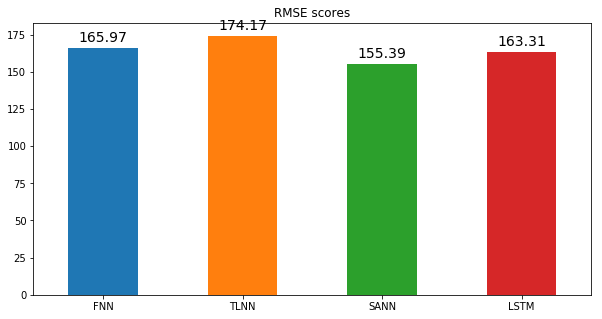

In [83]:
for district in districts_of_interest:
    temp_data = rainfall_season_data[['Date', 'Year', 'Month', district]]
    for month in months_of_interest:
        df = temp_data[temp_data.Month == month]
        df.index = range(len(df))
        df = df[['Date', district]]
        dates = df.Date
        
        rainfall_data = pd.DataFrame({'Precipitation': df[district][:-5]})
        rainfall_data.index = dates[:-5]
        
        test_rainfall_data = pd.DataFrame({'Precipitation': df[district][-5:]})
        test_rainfall_data.index = dates[-5:]
        
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit(rainfall_data)

        output_folder = STORAGE_FOLDER + district + '_' + month + '/'
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        
        ANN = reload(ANN)
        RMSE_info = ANN.compare_ANN_methods(rainfall_data, test_rainfall_data, scaler, 
                        parameters_FNN, parameters_TLNN, parameters_SANN, parameters_LSTM, future_steps, output_folder)

        ANN = reload(ANN)
        ANN.save_RMSE_info(output_folder, RMSE_info)
        
        break
    break

In [ ]:
for district in districts:
    print(district)
    
    rainfall_data = pd.DataFrame({'Precipitation': maharashtra_data[district][:-60]})
    rainfall_data.index = dates[:-60]
    
    test_rainfall_data = pd.DataFrame({'Precipitation': maharashtra_data[district][-60:]})
    test_rainfall_data.index = dates[-60:]
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(rainfall_data)
    
    output_folder = STORAGE_FOLDER + district + '/'
    print(output_folder)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    ARIMA = reload(ARIMA)
    forecasted_values = ARIMA.ARIMA(rainfall_data, output_folder, future_steps)
    
    errors = test_rainfall_data.Precipitation - forecasted_values
    ARIMA_actual_forecasted = pd.DataFrame({'Actual': test_rainfall_data.Precipitation, 
                                           'Forecasted': forecasted_values,
                                           'Errors': errors})
    ARIMA_actual_forecasted.to_csv(output_folder + '/' + 'ARIMA_actual_and_forecasted.csv')
    
    plt.figure(figsize=(10,5))
    plt.plot(ARIMA_actual_forecasted.drop(columns=['Actual', 'Forecasted']), color='blue', label='Error: Actual - Forecasted')
    plt.xlabel('Year')
    plt.ylabel('Error')
    plt.legend(loc='best')
    plt.title('ARIMA - Error: Actual - Forecasted')
    plt.savefig(output_folder + 'ARIMA_error_plot'  + '.png')
    
    y_true = test_rainfall_data.ix[:int(future_steps)]
    plt.figure(figsize=(10,5))
    plt.plot(y_true, color='green', label='Actual values')
    plt.plot(forecasted_values, color='red', label='Forecasted values')
    plt.xlabel('Year')
    plt.ylabel('Monthly mean Precipitation')
    plt.legend(loc='best')
    plt.title('ARIMA - Comaprison: Actual vs Forecasted')
    plt.savefig(output_folder + 'ARIMA_best_forecast'  + '.png')
    
    mse, mae, mape, rmse = calculate_performance(y_true, forecasted_values)
    RMSE_score = pd.read_csv(output_folder + 'RMSE_score.csv')
    best_method = RMSE_score.iloc[RMSE_score.RMSE.argmin]['Unnamed: 0']
    RMSE_score = RMSE_score.append({'Unnamed: 0': 'ARIMA', 'RMSE': str(rmse)}, ignore_index=True)
    RMSE_score.RMSE = RMSE_score.RMSE.astype('float')
    
    current_best_method = RMSE_score.iloc[RMSE_score.RMSE.argmin]['Unnamed: 0']
    
    RMSE_score = RMSE_score.set_index('Unnamed: 0')
    RMSE_score.to_csv(output_folder + 'RMSE_score.csv')
    
    axis = RMSE_score.plot(kind='bar', figsize=(10,5), rot=0, title='RMSE scores')
    axis.set_xlabel('Method name')
    for p in axis.patches:
        axis.annotate(np.round(p.get_height(),decimals=2), 
                    (p.get_x()+p.get_width()/2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 10), 
                    textcoords='offset points', fontsize=14, color='black')
    
    fig = axis.get_figure()
    fig.savefig(output_folder + 'RMSE.png')
    
    if current_best_method == 'ARIMA':
        y_true = test_rainfall_data.ix[:int(future_steps)]
        plt.figure(figsize=(10,5))
        plt.plot(y_true, color='green', label='Actual values')
        plt.plot(forecasted_values, color='red', label='Forecasted values')
        plt.xlabel('Year')
        plt.ylabel('Monthly mean Precipitation')
        plt.legend(loc='best')
        plt.title('Best of all: ARIMA - Comaprison: Actual vs Forecasted')
        plt.savefig(output_folder + 'BEST_FORECAST_ARIMA'  + '.png')
        print('abhi')
        os.remove(output_folder + 'BEST_FORECAST_' + best_method + '.png')